In [1]:
import ml
reload(ml)
from ml import *
import timeit
import scipy
import operator
import numba
import swifter
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
from __future__ import division
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

In [2]:
bid_features = ['ListingKey', 'CreationDate', "MemberKey", "Bid_Key",
                "ParticipationAmount", "MinimumRate", "MinimumYield",
                "ListingStatus", 'Status'] 
completed_bids_features = ["Member_Key", "MemberKey", "ListingStatus"]
winning_bids_features = ["Member_Key", "MemberKey", "Status"]
total_bids_features = ["Member_Key", "MemberKey", "Bid_Key"]
# member_keys = list(set(bid_data.MemberKey))
member_features = ['Mem_Key', 'CreationDate', 'Roles']
listing_features = ['Lst_Key', 'CreationDate', 'StartDate']
project_features = ['ListingKey', 'FundedOrNot', 'RepaidOrNot']

## Member Creation Date

In [3]:
# Member Data: Member Creation Date
member_data = pd.read_csv("../Data/member.txt", sep="|")
member_data = member_data[member_features]
member_data = member_data.rename(index=str, columns={"CreationDate": "MemberCreationDate", 
                                                     "Mem_Key": "MemberKey", 
                                                     "Roles": "MemberRoles"})
member_data.sample(5)
# member_data.columns

,MemberKey,MemberCreationDate,MemberRoles
1050207,FE753525321959131D27780,2011-09-13 12:36:55,NaN
268556,6E16338991861494493BAB2,2007-05-09 12:20:00,Borrower
265048,C8CE3388285805497E574A5,2007-05-06 19:35:00,NaN
933313,CC7F3497153571991938D94,2010-10-05 13:40:52,Borrower
1045404,538C3525080545276A8D259,2011-09-02 01:39:27,NaN


## Listing Creation & Start Date

In [4]:
listing_data = pd.read_csv('../Data/listing.txt', sep="|")
listing_data = listing_data[listing_features]
listing_data["Listing_Key"] = listing_data.Lst_Key
listing_data = listing_data.rename(index=str, 
                                   columns={"Lst_Key": "ListingKey", 
                                            "CreationDate": "ListingCreationDate",
                                            "StartDate": "ListingStartDate"})
listing_data.head()

,ListingKey,ListingCreationDate,ListingStartDate,Listing_Key
0,C0933365069571441D6651D,2006-02-25 05:51:10,2006-02-25 05:51:10,C0933365069571441D6651D
1,06413364714455220D3A5A5,2006-03-15 17:17:51,2006-03-15 17:17:51,06413364714455220D3A5A5
2,9D5E336577848196944F197,2006-03-15 21:52:45,2006-03-15 21:52:45,9D5E336577848196944F197
3,06193365103109718753985,2006-03-22 11:34:35,2006-03-22 11:34:35,06193365103109718753985
4,1C0733660810131582558C3,2006-03-22 12:23:19,2006-03-22 12:23:19,1C0733660810131582558C3


## Project Data

In [5]:
project_data = pd.read_csv('../Data/ProjectLevelData.txt', sep="|")
project_data = project_data[project_features]
project_data.head()

,ListingKey,FundedOrNot,RepaidOrNot
0,00003383856420083050622,False,NaN
1,00003405662222292C12B86,False,NaN
2,000034085359462718B9059,False,NaN
3,000034203787284229CBEF1,False,NaN
4,00003423466422120D65CA3,False,NaN


## Bid Data

In [6]:
# Bid Data: Listing Key and Bid Creation Date
bid_data = pd.read_csv("../Data/bid_notick.txt", sep="|")
bid_data = bid_data[bid_features]
bid_data['Member_Key'] = bid_data.MemberKey
bid_data = bid_data.rename(index=str, columns={"CreationDate": "BidCreationDate",
                                               "ParticipationAmount": "BidAmount",
                                               "MinimumRate": "BidMinimumRate",
                                               "MinimumYield": "BidMinimumYield"})
bid_data.sample(5)
# bid_data.columns

,ListingKey,BidCreationDate,MemberKey,Bid_Key,BidAmount,BidMinimumRate,BidMinimumYield,ListingStatus,Status,Member_Key
6448567,C3B83469907269092F86E32,2009-11-23 16:49:18,3EDE3466480598965D8595D,4AEB3573654970564AB19EE,25.000,nan,nan,Completed,Winning,3EDE3466480598965D8595D
2990346,AE5934068403867834D0422,2007-12-04 17:59:18,A9CE337380795529254F732,E474351062231487287FF3E,50.000,nan,nan,Completed,Winning,A9CE337380795529254F732
6552460,9B4A3471059241679C2F433,2009-12-28 09:35:02,6DEA336547129900763B95D,6A9C3575363055606943458,25.000,nan,nan,Completed,Winning,6DEA336547129900763B95D
6871501,28D03478799821347D58783,2010-03-24 09:30:36,38993478915716500784130,53F33583143214171BD9075,25.000,nan,nan,Completed,Winning,38993478915716500784130
9312889,770235351504506495E0041,2012-01-17 09:06:55,8F7234195270342152D849B,A43A36414693729116DA4F2,41.000,nan,nan,Completed,Winning,8F7234195270342152D849B


## Merge Dataframes

In [7]:
data = bid_data.merge(member_data, on="MemberKey", how="left")
data = data.merge(listing_data, on="ListingKey", how="left")
data = data.merge(project_data, on="ListingKey", how="left")
data["Listing_Key"] = data.ListingKey
# data['BidCreationDate'] = pd.to_datetime(data.BidCreationDate)
# data['MemberCreationDate'] = pd.to_datetime(data.MemberCreationDate)
# data['ListingCreationDate'] = pd.to_datetime(data.ListingCreationDate)
# data['ListingStartDate'] = pd.to_datetime(data.ListingStartDate)
print len(bid_data)
print len(member_data)
print len(listing_data)
print len(project_data)
print len(data)
data.head()

9732656
1340026
415157
235753
9733452


,ListingKey,BidCreationDate,MemberKey,Bid_Key,BidAmount,BidMinimumRate,BidMinimumYield,ListingStatus,Status,Member_Key,MemberCreationDate,MemberRoles,ListingCreationDate,ListingStartDate,Listing_Key,FundedOrNot,RepaidOrNot
0,D6473365888221963456102,2006-02-21 20:23:20,F4273365023760472DBD934,0F12336634427919902FE93,0.000,0.250,0.245,Completed,Outbid,F4273365023760472DBD934,2005-10-31 00:17:00,"Borrower,Lender,Group Leader,TRADER",2006-02-15 14:21:25,2006-02-15 14:21:25,D6473365888221963456102,True,True
1,D6473365888221963456102,2006-02-21 22:50:00,F4273365023760472DBD934,87F333655285187004B2EE8,50.000,nan,nan,Completed,Winning,F4273365023760472DBD934,2005-10-31 00:17:00,"Borrower,Lender,Group Leader,TRADER",2006-02-15 14:21:25,2006-02-15 14:21:25,D6473365888221963456102,True,True
2,3B09336533376614186EEF7,2006-02-28 00:16:01,F4273365023760472DBD934,9DB53365565361098646F41,0.000,0.045,0.040,Expired,Outbid,F4273365023760472DBD934,2005-10-31 00:17:00,"Borrower,Lender,Group Leader,TRADER",2006-02-16 12:12:09,2006-02-16 12:12:09,3B09336533376614186EEF7,False,NaN
3,601833660859080305A2AC3,2006-02-28 20:06:43,F4273365023760472DBD934,7284336544796747049D125,0.000,0.069,0.064,Completed,Outbid,F4273365023760472DBD934,2005-10-31 00:17:00,"Borrower,Lender,Group Leader,TRADER",2006-02-22 09:54:17,2006-02-22 09:54:17,601833660859080305A2AC3,True,True
4,601833660859080305A2AC3,2006-03-01 09:27:50,F4273365023760472DBD934,F3FD3365245307569E84B9F,50.000,nan,nan,Completed,Winning,F4273365023760472DBD934,2005-10-31 00:17:00,"Borrower,Lender,Group Leader,TRADER",2006-02-22 09:54:17,2006-02-22 09:54:17,601833660859080305A2AC3,True,True


In [8]:
del bid_data
del member_data
del listing_data
del project_data

In [9]:
hashmap = dict()
memberkeys = list(set(data.MemberKey))
len(memberkeys)

65756

In [10]:
data.to_csv("bid_fe.csv", index=False)

In [11]:
# counter = 0
# for key in memberkeys:
#     hashmap[key] = data.query("MemberKey == '{key}'")
#     counter = counter+1
#     print counter
# #     if counter%10000 == 0:
# #         print counter

1. LenderTotalBids

2. LenderWinningBids

LenderWinningBidRate

3. LenderTotalListings

4. LenderCompletedListings

LenderListingCompletionRate

5. LenderRepaidListings

LenderLoanRepaymentSuccessRate

6. LenderAge

# Lender Bids Feature Engineering

In [61]:
start = timeit.default_timer()    
sample_data = data[data.MemberKey=="616E338020439193667EADC"]
stop = timeit.default_timer()
print "Dataframe created in {0} seconds".format((stop-start)) 
sample_data[["MemberKey", "ListingKey", "ListingStartDate", "Bid_Key","BidCreationDate", "Status"]].sort_values("ListingStartDate")

Dataframe created in 0.9697476 seconds


,MemberKey,ListingKey,ListingStartDate,Bid_Key,BidCreationDate,Status
974059,616E338020439193667EADC,178933814537634462D4154,2007-02-19 17:24:41,B5A03381766156986311194,2007-02-22 13:11:48,Outbid
999467,616E338020439193667EADC,3376338117741628200097E,2007-02-19 20:48:46,6C013382294432162048FE9,2007-03-01 19:23:16,Winning
978796,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,95E133822301859598E73B3,2007-02-22 13:21:58,Outbid
1020431,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,691D338347143849355C0F1,2007-02-23 20:43:08,Outbid
1020440,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,1D253383193298436130268,2007-03-01 19:37:45,Outbid
1025427,616E338020439193667EADC,6BE43382811303485D2E231,2007-02-23 09:09:15,C1BF338356575227566C5AC,2007-03-01 19:33:02,Winning
1078246,616E338020439193667EADC,42723381901706255546562,2007-03-01 19:17:33,AE213383949117391D29FF7,2007-03-11 19:15:04,Winning
1094425,616E338020439193667EADC,1D823383233930356E4304E,2007-03-03 16:20:45,33363384131860842B028B6,2007-03-10 16:07:50,Winning
1151338,616E338020439193667EADC,703E3384102549043B12A27,2007-03-10 10:21:48,683F338361037453702A594,2007-03-17 07:29:53,Winning
4233166,616E338020439193667EADC,09773417671295020A4F8D5,2008-04-08 12:12:12,052F35217058836562374C3,2008-04-16 10:26:13,Outbid


## Lender Winning Bid

In [40]:
# f_winning_bids = {'MemberKey': ['max'],
#                   'Status': ['count']
# }

# # Lender winning bids: funded and unfunded listings
# member_winning_bids = pd.DataFrame(bid_data[winning_bids_features].loc[bid_data["Status"]=="Winning"].groupby("Member_Key").agg(f_winning_bids).as_matrix())
# member_winning_bids = member_winning_bids.rename(index=str, 
#                                                columns={0: "LenderWinningBids", 
#                                                         1: "MemberKey"})
# member_winning_bids.sample(5)

,LenderWinningBids,MemberKey
9247,8,255933936119743227CF2E5
35281,116,8DDC3375613830737579A39
55531,73,DF093376577687246AB73DD
24329,8,616E338020439193667EADC
50733,160,CBD933716181300637B4359


In [62]:
@numba.jit
def lender_winning_bids(x):
    return data.query("Status == 'Winning' and ListingStartDate < '{0}' and MemberKey == '{1}'".format(x["ListingStartDate"], x["MemberKey"]))["Bid_Key"].nunique()

start = timeit.default_timer()    
# data["LenderWinningBids"] = 
sample_data["LenderWinningBids"] = data[["MemberKey", "ListingStartDate"]][data.MemberKey=="616E338020439193667EADC"].swifter.apply(lender_winning_bids, axis=1)
stop = timeit.default_timer()
print "Feature engineering completed in {0} seconds".format((stop-start)) 
sample_data[["MemberKey", "ListingKey", "ListingStartDate", "Bid_Key", "BidCreationDate", "Status", "LenderWinningBids"]].sort_values("ListingStartDate")

Feature engineering completed in 110.9792462 seconds


,MemberKey,ListingKey,ListingStartDate,Bid_Key,BidCreationDate,Status,LenderWinningBids
974059,616E338020439193667EADC,178933814537634462D4154,2007-02-19 17:24:41,B5A03381766156986311194,2007-02-22 13:11:48,Outbid,0
999467,616E338020439193667EADC,3376338117741628200097E,2007-02-19 20:48:46,6C013382294432162048FE9,2007-03-01 19:23:16,Winning,0
978796,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,95E133822301859598E73B3,2007-02-22 13:21:58,Outbid,1
1020431,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,691D338347143849355C0F1,2007-02-23 20:43:08,Outbid,1
1020440,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,1D253383193298436130268,2007-03-01 19:37:45,Outbid,1
1025427,616E338020439193667EADC,6BE43382811303485D2E231,2007-02-23 09:09:15,C1BF338356575227566C5AC,2007-03-01 19:33:02,Winning,1
1078246,616E338020439193667EADC,42723381901706255546562,2007-03-01 19:17:33,AE213383949117391D29FF7,2007-03-11 19:15:04,Winning,2
1094425,616E338020439193667EADC,1D823383233930356E4304E,2007-03-03 16:20:45,33363384131860842B028B6,2007-03-10 16:07:50,Winning,3
1151338,616E338020439193667EADC,703E3384102549043B12A27,2007-03-10 10:21:48,683F338361037453702A594,2007-03-17 07:29:53,Winning,4
4233166,616E338020439193667EADC,09773417671295020A4F8D5,2008-04-08 12:12:12,052F35217058836562374C3,2008-04-16 10:26:13,Outbid,5


## Lender Total Bids

In [38]:
# f_total_bids = {'MemberKey': ['max'],
#                 'Bid_Key': ['count']
# }
# # Member total bids: funded and unfunded listings
# member_total_bids = pd.DataFrame(bid_data[total_bids_features].groupby("Member_Key").agg(f_total_bids).as_matrix())
# member_total_bids = member_total_bids.rename(index=str, 
#                                            columns={0: "MemberKey", 
#                                                     1: "LenderTotalBids"})
# member_total_bids.sample(5)

,MemberKey,LenderTotalBids
27384,6A773403381691836272D17,33
56893,DD853376224851444D8C472,10
14244,37AB33662743400950DAB1D,4
5585,1619336570820086872D486,1102
57794,E11E3386884643334FA626C,187


In [63]:
@numba.jit
def lender_total_bids(x):
    return sample_data.query("ListingStartDate < '{0}' and MemberKey == '{1}'".format(x["ListingStartDate"], x["MemberKey"]))["Bid_Key"].nunique()

start = timeit.default_timer()    
sample_data["LenderTotalBids"] = data[["MemberKey", "ListingStartDate"]][data.MemberKey=="616E338020439193667EADC"].swifter.apply(lender_total_bids, axis=1)
stop = timeit.default_timer()
print "Feature engineering completed in {0} seconds".format((stop-start)) 
sample_data[["MemberKey", "ListingKey", "ListingStartDate", "Bid_Key", "BidCreationDate", "Status","LenderWinningBids", "LenderTotalBids"]].sort_values("ListingStartDate")

Feature engineering completed in 1.6981857 seconds


,MemberKey,ListingKey,ListingStartDate,Bid_Key,BidCreationDate,Status,LenderWinningBids,LenderTotalBids
974059,616E338020439193667EADC,178933814537634462D4154,2007-02-19 17:24:41,B5A03381766156986311194,2007-02-22 13:11:48,Outbid,0,0
999467,616E338020439193667EADC,3376338117741628200097E,2007-02-19 20:48:46,6C013382294432162048FE9,2007-03-01 19:23:16,Winning,0,1
978796,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,95E133822301859598E73B3,2007-02-22 13:21:58,Outbid,1,2
1020431,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,691D338347143849355C0F1,2007-02-23 20:43:08,Outbid,1,2
1020440,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,1D253383193298436130268,2007-03-01 19:37:45,Outbid,1,2
1025427,616E338020439193667EADC,6BE43382811303485D2E231,2007-02-23 09:09:15,C1BF338356575227566C5AC,2007-03-01 19:33:02,Winning,1,5
1078246,616E338020439193667EADC,42723381901706255546562,2007-03-01 19:17:33,AE213383949117391D29FF7,2007-03-11 19:15:04,Winning,2,6
1094425,616E338020439193667EADC,1D823383233930356E4304E,2007-03-03 16:20:45,33363384131860842B028B6,2007-03-10 16:07:50,Winning,3,7
1151338,616E338020439193667EADC,703E3384102549043B12A27,2007-03-10 10:21:48,683F338361037453702A594,2007-03-17 07:29:53,Winning,4,8
4233166,616E338020439193667EADC,09773417671295020A4F8D5,2008-04-08 12:12:12,052F35217058836562374C3,2008-04-16 10:26:13,Outbid,5,9


## Compute Lender Winning Bid Rate

In [64]:
# lender distinct winning bids / lender total bids
sample_data["LenderBidWinningRate"] = sample_data['LenderWinningBids'] / sample_data['LenderTotalBids']
sample_data[["MemberKey", "ListingKey", "ListingStartDate", "Bid_Key", "BidCreationDate", "Status","LenderWinningBids", "LenderTotalBids", "LenderBidWinningRate"]].sort_values("ListingStartDate")

,MemberKey,ListingKey,ListingStartDate,Bid_Key,BidCreationDate,Status,LenderWinningBids,LenderTotalBids,LenderBidWinningRate
974059,616E338020439193667EADC,178933814537634462D4154,2007-02-19 17:24:41,B5A03381766156986311194,2007-02-22 13:11:48,Outbid,0,0,nan
999467,616E338020439193667EADC,3376338117741628200097E,2007-02-19 20:48:46,6C013382294432162048FE9,2007-03-01 19:23:16,Winning,0,1,0.000
978796,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,95E133822301859598E73B3,2007-02-22 13:21:58,Outbid,1,2,0.500
1020431,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,691D338347143849355C0F1,2007-02-23 20:43:08,Outbid,1,2,0.500
1020440,616E338020439193667EADC,571333811998077801F5FA6,2007-02-22 11:52:03,1D253383193298436130268,2007-03-01 19:37:45,Outbid,1,2,0.500
1025427,616E338020439193667EADC,6BE43382811303485D2E231,2007-02-23 09:09:15,C1BF338356575227566C5AC,2007-03-01 19:33:02,Winning,1,5,0.200
1078246,616E338020439193667EADC,42723381901706255546562,2007-03-01 19:17:33,AE213383949117391D29FF7,2007-03-11 19:15:04,Winning,2,6,0.333
1094425,616E338020439193667EADC,1D823383233930356E4304E,2007-03-03 16:20:45,33363384131860842B028B6,2007-03-10 16:07:50,Winning,3,7,0.429
1151338,616E338020439193667EADC,703E3384102549043B12A27,2007-03-10 10:21:48,683F338361037453702A594,2007-03-17 07:29:53,Winning,4,8,0.500
4233166,616E338020439193667EADC,09773417671295020A4F8D5,2008-04-08 12:12:12,052F35217058836562374C3,2008-04-16 10:26:13,Outbid,5,9,0.556


In [65]:
data.Member_Key.nunique()

65756

## Merge Member Bid Data

In [41]:
# member_df = pd.DataFrame()
# member_df["MemberKey"] = member_keys
# # Lender features from funded and unfunded listings
# member_bids = member_df.merge(member_total_bids, on="MemberKey", how="inner")
# member_bids = member_bids.merge(member_completed_bids, on="MemberKey", how="left")
# member_bids = member_bids.merge(member_winning_bids, on="MemberKey", how="left")
# # Lender distinct completed bids / lender total bids
# member_bids["LenderBidCompletionRate"] = member_bids['LenderCompletedBids'] / member_bids['LenderTotalBids']
# # lender distinct winning bids / lender total bids
# member_bids["LenderBidWinningRate"] = member_bids['LenderWinningBids'] / member_bids['LenderTotalBids']
# member_bids = member_bids.fillna(0)
# member_bids.sample(10)

,MemberKey,LenderTotalBids,LenderCompletedBids,LenderWinningBids,LenderBidCompletionRate,LenderBidWinningRate
35089,F6F93364714434896A3E1CD,289,198,169,0.685,0.585
18441,67913419417479468CE1195,2,2,0,1.000,0.000
14583,C98F337242471622605809E,12,6,9,0.500,0.750
10730,F19934711093908520B3771,90,55,70,0.611,0.778
32454,CFDB34155659737631976D3,34,23,18,0.676,0.529
47569,54093425548736641E5E79F,4,3,0,0.750,0.000
43514,B4BE342179958181252A415,41,21,14,0.512,0.341
30756,F4E63377859068613610599,8,8,6,1.000,0.750
17578,B24633727614093505D5A9F,3,3,1,1.000,0.333
26878,62003407149589698B4C832,113,88,27,0.779,0.239


# Lender Listing Feature Engineering

## Member Total Listings

In [33]:
f_cl = {'MemberKey': ['max'],
        'ListingKey': ['nunique']  
}
# Total number of lender's distinct listings
member_total_listings = bid_data[["ListingKey", "MemberKey"]]
member_total_listings["Member_Key"] = bid_data["MemberKey"]
member_total_listings = pd.DataFrame(member_total_listings.groupby(["Member_Key"]).agg(f_cl).as_matrix())
member_total_listings = member_total_listings.rename(index=str, columns={0: "MemberKey", 1: 'LenderTotalListings'})
print len(member_total_listings)
member_total_listings.head()

65756


,MemberKey,LenderTotalListings
0,0000340501560805347A59F,419
1,0000353692604268289A4B7,13
2,00033402143834852446E26,19
3,000433659400311562A26CE,1514
4,00063381446480331D5115B,78


## Member Completed Listings

In [34]:
# Total number of lender's distinct completed listings
member_completed_listings = bid_data.loc[bid_data['ListingStatus']=='Completed'][["ListingKey", "MemberKey"]]

member_completed_listings["Member_Key"] = member_completed_listings["MemberKey"]
member_completed_listings = pd.DataFrame(member_completed_listings.groupby(["Member_Key"]).agg(f_cl).as_matrix())
member_completed_listings = member_completed_listings.rename(index=str, columns={0: "MemberKey", 1: 'LenderCompletedListings'})
member_completed_listings.head()
print len(member_completed_listings)
member_completed_listings.head()

64325


,MemberKey,LenderCompletedListings
0,0000340501560805347A59F,338
1,0000353692604268289A4B7,7
2,00033402143834852446E26,13
3,000433659400311562A26CE,981
4,00063381446480331D5115B,61


## Listing Data

In [35]:
# Filter only funded listings
listing_data = pd.read_csv("../Data/ProjectLevelData.txt", sep="|")
listing_data = listing_data.loc[(listing_data['RepaidOrNot']==True) | (listing_data['RepaidOrNot']==False)]
listing_data = listing_data[listing_features]

## Member Repaid Listings

In [36]:
# Member Repaid Listings
member_repaid_listings = listing_data.merge(bid_data, on="ListingKey")
member_repaid_listings = member_repaid_listings.loc[member_repaid_listings['RepaidOrNot']==True][["ListingKey", "MemberKey"]]

member_repaid_listings["Member_Key"] = member_repaid_listings["MemberKey"]
member_repaid_listings = pd.DataFrame(member_repaid_listings.groupby(["Member_Key"]).agg(f_cl).as_matrix())
member_repaid_listings = member_repaid_listings.rename(index=str, columns={0: "MemberKey", 1: 'LenderRepaidListings'})
member_repaid_listings.head()
print len(member_repaid_listings)
member_repaid_listings.head(5)

59410


,MemberKey,LenderRepaidListings
0,0000340501560805347A59F,261
1,00033402143834852446E26,3
2,000433659400311562A26CE,416
3,00063381446480331D5115B,43
4,00063385178743731192B7E,75


## Merge Member Listing Data

In [37]:
member_listings = member_total_listings.merge(member_completed_listings, on="MemberKey", how="left")
member_listings = member_listings.merge(member_repaid_listings, on="MemberKey", how="left")
member_listings = member_listings.fillna(0)
member_listings["LenderListingSuccessRate"] = member_listings.LenderCompletedListings / member_listings.LenderTotalListings
member_listings["LenderRepaymentSuccessRate"] = member_listings.LenderRepaidListings / member_listings.LenderCompletedListings
print len(member_total_listings)
print len(member_completed_listings)
print len(member_repaid_listings)
print len(member_listings)
member_listings.sample(5)

65756
64325
59410
65756


,MemberKey,LenderTotalListings,LenderCompletedListings,LenderRepaidListings,LenderListingSuccessRate,LenderRepaymentSuccessRate
14632,390C342641291549526AFEB,91,48,22,0.527,0.458
34887,88083415968310106CD1BC2,31,19,4,0.613,0.211
49612,C1383413011108741FA4B65,36,19,9,0.528,0.474
12962,32AB35155703798206B4644,2,2,0,1.000,0.000
645,02713417764695412255FE9,58,37,26,0.638,0.703


## Merge Member Data

In [43]:
data = listing_data.merge(bid_data, on="ListingKey")
data = data.merge(member_data, on="MemberKey")
data = data.merge(member_listings, on="MemberKey")
data = data.merge(member_bids, on="MemberKey", how="left")
data = data.fillna(0)
data["Listing_Key"] = data.ListingKey
data["BidCreationDate"] = pd.to_datetime(data.BidCreationDate)
data["MemberCreationDate"] = pd.to_datetime(data.MemberCreationDate)
data["LenderAge"] = (data.BidCreationDate - data.MemberCreationDate).dt.days
data["LenderDecentralization"] = data.LenderCompletedListings / data.LenderCompletedBids
data = data.drop(["MemberKey", "Member_Key", "Bid_Key", "BidCreationDate", "MemberCreationDate", "RepaidOrNot", "ListingStatus", "Status"], axis=1)
data.head(10)

,ListingKey,LenderTotalListings,LenderCompletedListings,LenderRepaidListings,LenderListingSuccessRate,LenderRepaymentSuccessRate,LenderTotalBids,LenderCompletedBids,LenderWinningBids,LenderBidCompletionRate,LenderBidWinningRate,Listing_Key,LenderAge,LenderDecentralization
0,00033425227988088FA6752,616,396,158,0.643,0.399,706,464,557,0.657,0.789,00033425227988088FA6752,264,0.853
1,00033425227988088FA6752,616,396,158,0.643,0.399,706,464,557,0.657,0.789,00033425227988088FA6752,265,0.853
2,006934251746069077560C9,616,396,158,0.643,0.399,706,464,557,0.657,0.789,006934251746069077560C9,283,0.853
3,00943489018254614AA7153,616,396,158,0.643,0.399,706,464,557,0.657,0.789,00943489018254614AA7153,1026,0.853
4,00973426811525421411E03,616,396,158,0.643,0.399,706,464,557,0.657,0.789,00973426811525421411E03,287,0.853
5,00973426811525421411E03,616,396,158,0.643,0.399,706,464,557,0.657,0.789,00973426811525421411E03,287,0.853
6,01083415991046434E155DD,616,396,158,0.643,0.399,706,464,557,0.657,0.789,01083415991046434E155DD,177,0.853
7,01113489432385626E46868,616,396,158,0.643,0.399,706,464,557,0.657,0.789,01113489432385626E46868,1029,0.853
8,01863415609505126C2D330,616,396,158,0.643,0.399,706,464,557,0.657,0.789,01863415609505126C2D330,161,0.853
9,02F73423672949966CF27EE,616,396,158,0.643,0.399,706,464,557,0.657,0.789,02F73423672949966CF27EE,266,0.853


## Aggregate Listing Data

In [61]:
f_avg = {'ListingKey': ['max'],
         'LenderTotalListings': ['mean'],
         'LenderCompletedListings': ['mean'],
         'LenderRepaidListings': ['mean'],
         'LenderListingSuccessRate': ['mean'],
         'LenderRepaymentSuccessRate': ['mean'],
         'LenderTotalBids': ['mean'],
         'LenderCompletedBids': ['mean'],
         'LenderWinningBids': ['mean'],
         'LenderBidCompletionRate': ['mean'],
         'LenderBidWinningRate': ['mean'],
         'LenderAge': ['mean'],
         'LenderDecentralization': ['mean']
}
lender_mean_attr = pd.DataFrame(data.groupby(["Listing_Key"]).agg(f_avg).as_matrix())
lender_mean_attr = lender_mean_attr.rename(index=str, columns={0: "LenderAvgRepaidListings", 
                                                             1: "LenderAvgWinningBids",
                                                             2: "ListingKey",
                                                             3: "LenderAvgDecentralization",
                                                             4: "LenderAvgAge",
                                                             5: "LenderAvgBidCompletionRate",
                                                             6: "LenderAvgCompletedBids",
                                                             7: "LenderAvgListings",
                                                             8: "LenderAvgListingSuccessRate",
                                                             9: "LenderAvgRepaymentSuccessRate",
                                                             10: "LenderAvgBidWinningRate",
                                                             11: "LenderAvgBids",
                                                             12: "LenderAvgCompletedListings"})
lender_mean_attr.head()

,LenderAvgRepaidListings,LenderAvgWinningBids,ListingKey,LenderAvgDecentralization,LenderAvgAge,LenderAvgBidCompletionRate,LenderAvgCompletedBids,LenderAvgListings,LenderAvgListingSuccessRate,LenderAvgRepaymentSuccessRate,LenderAvgBidWinningRate,LenderAvgBids,LenderAvgCompletedListings
0,267.333,802.933,00033425227988088FA6752,0.845,240.533,0.655,679.800,936.200,0.645,0.471,0.735,1091.400,563.867
1,331.433,808.967,000433785890431972B4743,0.844,76.500,0.681,830.133,963.200,0.673,0.457,0.699,1203.433,639.733
2,371.504,676.156,00083422661625108817246,0.886,234.660,0.750,679.723,903.567,0.740,0.669,0.641,991.844,609.213
3,123.500,124.500,000A34209897973969CFA81,0.728,296.500,0.761,213.500,213.000,0.734,0.701,0.475,280.000,155.000
4,227.649,495.577,000D3410451511356B08F17,0.807,189.925,0.698,557.828,653.515,0.682,0.570,0.583,845.891,409.444


In [62]:
f_median = {'ListingKey': ['max'],
         'LenderTotalListings': ['median'],
         'LenderCompletedListings': ['median'],
         'LenderRepaidListings': ['median'],
         'LenderListingSuccessRate': ['median'],
         'LenderRepaymentSuccessRate': ['median'],
         'LenderTotalBids': ['median'],
         'LenderCompletedBids': ['median'],
         'LenderWinningBids': ['median'],
         'LenderBidCompletionRate': ['median'],
         'LenderBidWinningRate': ['median'],
         'LenderAge': ['median'],
         'LenderDecentralization': ['median']
}
lender_median_attr = pd.DataFrame(data.groupby(["Listing_Key"]).agg(f_median).as_matrix())
lender_median_attr = lender_median_attr.rename(index=str, columns={0: "LenderMedianRepaidListings", 
                                                                 1: "LenderMedianWinningBids",
                                                                 2: "ListingKey",
                                                                 3: "LenderMedianDecentralization",
                                                                 4: "LenderMedianAge",
                                                                 5: "LenderMedianBidCompletionRate",
                                                                 6: "LenderMedianCompletedBids",
                                                                 7: "LenderMedianListings",
                                                                 8: "LenderMedianListingSuccessRate",
                                                                 9: "LenderMedianRepaymentSuccessRate",
                                                                 10: "LenderMedianBidWinningRate",
                                                                 11: "LenderMedianBids",
                                                                 12: "LenderMedianCompletedListings"})
lender_median_attr.head()

,LenderMedianRepaidListings,LenderMedianWinningBids,ListingKey,LenderMedianDecentralization,LenderMedianAge,LenderMedianBidCompletionRate,LenderMedianCompletedBids,LenderMedianListings,LenderMedianListingSuccessRate,LenderMedianRepaymentSuccessRate,LenderMedianBidWinningRate,LenderMedianBids,LenderMedianCompletedListings
0,158.000,557.000,00033425227988088FA6752,0.853,256.000,0.675,464.000,616.000,0.643,0.480,0.795,706.000,396.000
1,131.000,385.500,000433785890431972B4743,0.886,57.500,0.689,320.000,424.000,0.681,0.447,0.678,503.500,293.000
2,146.000,218.000,00083422661625108817246,0.910,152.000,0.764,265.000,327.000,0.752,0.699,0.661,362.000,249.000
3,123.500,124.500,000A34209897973969CFA81,0.728,296.500,0.761,213.500,213.000,0.734,0.701,0.475,280.000,155.000
4,100.000,224.000,000D3410451511356B08F17,0.843,134.000,0.725,239.000,284.000,0.707,0.573,0.600,376.000,184.000


In [63]:
f_std = {'ListingKey': ['max'],
         'LenderTotalListings': ['std'],
         'LenderCompletedListings': ['std'],
         'LenderRepaidListings': ['std'],
         'LenderListingSuccessRate': ['std'],
         'LenderRepaymentSuccessRate': ['std'],
         'LenderTotalBids': ['std'],
         'LenderCompletedBids': ['std'],
         'LenderWinningBids': ['std'],
         'LenderBidCompletionRate': ['std'],
         'LenderBidWinningRate': ['std'],
         'LenderAge': ['std'],
         'LenderDecentralization': ['std']
}

lender_std_attr = pd.DataFrame(data.groupby(["Listing_Key"]).agg(f_std).as_matrix())
lender_std_attr = lender_std_attr.rename(index=str, columns={0: "LenderStdRepaidListings", 
                                                                 1: "LenderStdWinningBids",
                                                                 2: "ListingKey",
                                                                 3: "LenderStdDecentralization",
                                                                 4: "LenderStdAge",
                                                                 5: "LenderStdBidCompletionRate",
                                                                 6: "LenderStdCompletedBids",
                                                                 7: "LenderStdListings",
                                                                 8: "LenderStdListingSuccessRate",
                                                                 9: "LenderStdRepaymentSuccessRate",
                                                                 10: "LenderStdBidWinningRate",
                                                                 11: "LenderStdBids",
                                                                 12: "LenderStdCompletedListings"})
lender_std_attr.head()

,LenderStdRepaidListings,LenderStdWinningBids,ListingKey,LenderStdDecentralization,LenderStdAge,LenderStdBidCompletionRate,LenderStdCompletedBids,LenderStdListings,LenderStdListingSuccessRate,LenderStdRepaymentSuccessRate,LenderStdBidWinningRate,LenderStdBids,LenderStdCompletedListings
0,249.116,685.246,00033425227988088FA6752,0.102,150.722,0.132,672.730,807.599,0.133,0.066,0.140,1012.989,501.469
1,473.296,1019.304,000433785890431972B4743,0.124,66.231,0.126,1132.875,1180.206,0.129,0.127,0.144,1574.042,793.313
2,535.089,1109.999,00083422661625108817246,0.121,232.931,0.096,1028.943,1494.074,0.101,0.142,0.150,1617.786,933.035
3,137.886,115.258,000A34209897973969CFA81,0.003,389.616,0.003,212.839,213.546,0.012,0.192,0.061,278.600,154.149
4,292.980,792.415,000D3410451511356B08F17,0.157,168.584,0.116,730.338,918.100,0.124,0.129,0.184,1162.748,507.710


In [64]:
# Prepare final data
final_lender_data = lender_mean_attr.merge(lender_median_attr, on="ListingKey")
final_lender_data = final_lender_data.merge(lender_std_attr, on="ListingKey")
final_lender_data.head()

,LenderAvgRepaidListings,LenderAvgWinningBids,ListingKey,LenderAvgDecentralization,LenderAvgAge,LenderAvgBidCompletionRate,LenderAvgCompletedBids,LenderAvgListings,LenderAvgListingSuccessRate,LenderAvgRepaymentSuccessRate,...,LenderStdDecentralization,LenderStdAge,LenderStdBidCompletionRate,LenderStdCompletedBids,LenderStdListings,LenderStdListingSuccessRate,LenderStdRepaymentSuccessRate,LenderStdBidWinningRate,LenderStdBids,LenderStdCompletedListings
0,267.333,802.933,00033425227988088FA6752,0.845,240.533,0.655,679.800,936.200,0.645,0.471,...,0.102,150.722,0.132,672.730,807.599,0.133,0.066,0.140,1012.989,501.469
1,331.433,808.967,000433785890431972B4743,0.844,76.500,0.681,830.133,963.200,0.673,0.457,...,0.124,66.231,0.126,1132.875,1180.206,0.129,0.127,0.144,1574.042,793.313
2,371.504,676.156,00083422661625108817246,0.886,234.660,0.750,679.723,903.567,0.740,0.669,...,0.121,232.931,0.096,1028.943,1494.074,0.101,0.142,0.150,1617.786,933.035
3,123.500,124.500,000A34209897973969CFA81,0.728,296.500,0.761,213.500,213.000,0.734,0.701,...,0.003,389.616,0.003,212.839,213.546,0.012,0.192,0.061,278.600,154.149
4,227.649,495.577,000D3410451511356B08F17,0.807,189.925,0.698,557.828,653.515,0.682,0.570,...,0.157,168.584,0.116,730.338,918.100,0.124,0.129,0.184,1162.748,507.710


## Check Feature Correlation

In [65]:
listing_data = pd.read_csv("../Data/ProjectLevelData.txt", sep="|")
listing_data = listing_data.loc[(listing_data['RepaidOrNot']==True) | (listing_data['RepaidOrNot']==False)]
listing_data = listing_data[listing_features]
listing_data.head()

,ListingKey,RepaidOrNot
17,00033425227988088FA6752,True
21,000433785890431972B4743,False
38,00083422661625108817246,True
46,000A34209897973969CFA81,True
56,000D3410451511356B08F17,True


In [66]:
final_data = final_lender_data.merge(listing_data, on="ListingKey")
final_data['RepaidOrNot'] = final_data['RepaidOrNot'].astype(int)
final_data.head()

,LenderAvgRepaidListings,LenderAvgWinningBids,ListingKey,LenderAvgDecentralization,LenderAvgAge,LenderAvgBidCompletionRate,LenderAvgCompletedBids,LenderAvgListings,LenderAvgListingSuccessRate,LenderAvgRepaymentSuccessRate,...,LenderStdAge,LenderStdBidCompletionRate,LenderStdCompletedBids,LenderStdListings,LenderStdListingSuccessRate,LenderStdRepaymentSuccessRate,LenderStdBidWinningRate,LenderStdBids,LenderStdCompletedListings,RepaidOrNot
0,267.333,802.933,00033425227988088FA6752,0.845,240.533,0.655,679.800,936.200,0.645,0.471,...,150.722,0.132,672.730,807.599,0.133,0.066,0.140,1012.989,501.469,1
1,331.433,808.967,000433785890431972B4743,0.844,76.500,0.681,830.133,963.200,0.673,0.457,...,66.231,0.126,1132.875,1180.206,0.129,0.127,0.144,1574.042,793.313,0
2,371.504,676.156,00083422661625108817246,0.886,234.660,0.750,679.723,903.567,0.740,0.669,...,232.931,0.096,1028.943,1494.074,0.101,0.142,0.150,1617.786,933.035,1
3,123.500,124.500,000A34209897973969CFA81,0.728,296.500,0.761,213.500,213.000,0.734,0.701,...,389.616,0.003,212.839,213.546,0.012,0.192,0.061,278.600,154.149,1
4,227.649,495.577,000D3410451511356B08F17,0.807,189.925,0.698,557.828,653.515,0.682,0.570,...,168.584,0.116,730.338,918.100,0.124,0.129,0.184,1162.748,507.710,1


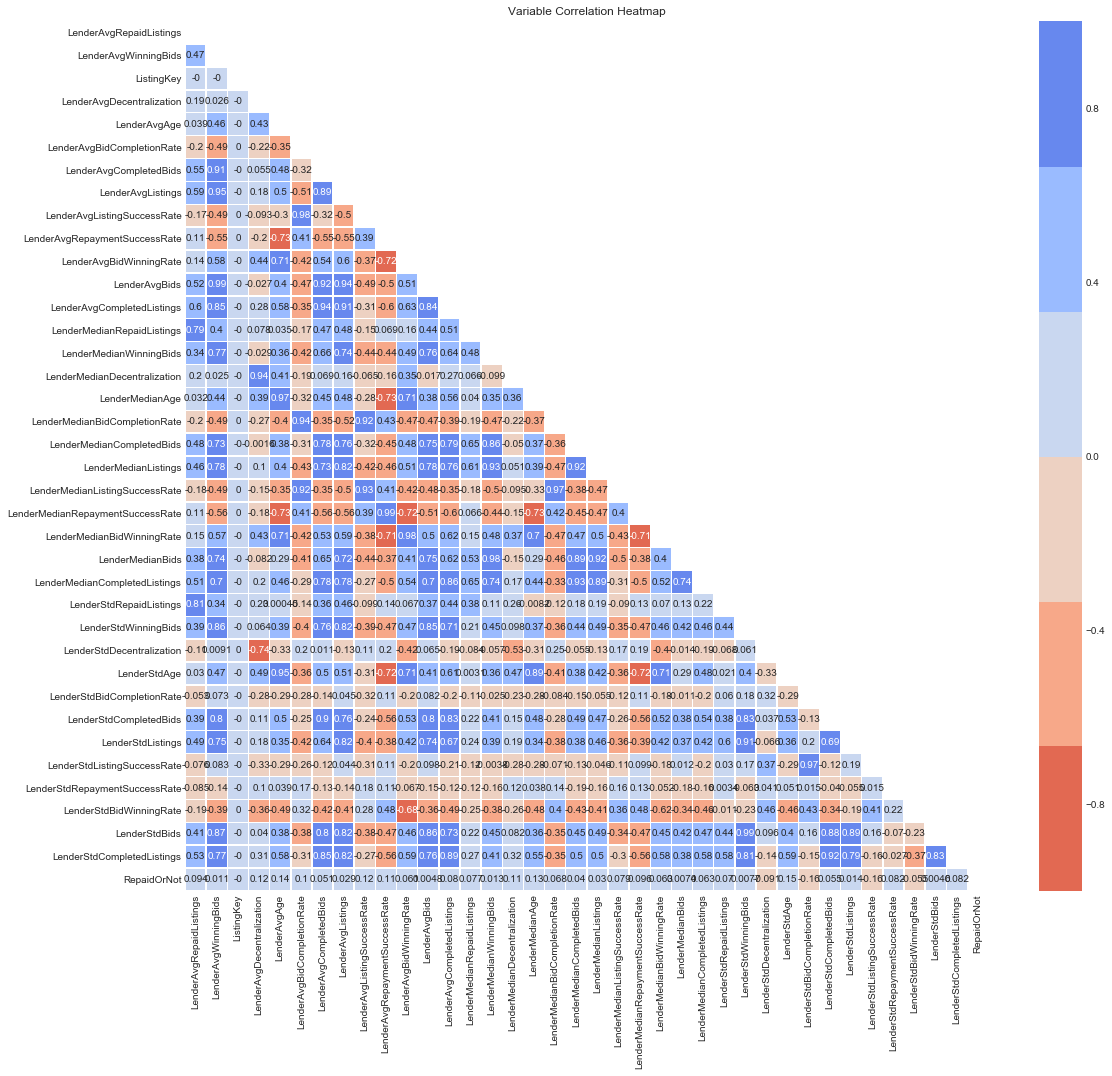

In [71]:
corr = final_data.apply(pd.to_numeric, errors='coerce').corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18,16))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("coolwarm_r"),
        mask = mask,
        linewidths=.5,
        vmin=-1,
        vmax=1,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

In [74]:
selected_features = ["ListingKey", "LenderStdAge", "LenderStdListingSuccessRate", "LenderAvgRepaymentSuccessRate", "LenderMedianListings"]

In [75]:
## Save data to csv file
final_lender_data[selected_features].to_csv("../Data/lender_listing_attr_filtered.csv", index=False)
final_lender_data.to_csv("../Data/lender_listing_attr.csv", index=False)